In [1]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import seaborn as sns
from kmodes.kprototypes import KPrototypes

In [2]:
#reading Dataset
df = pd.read_csv("Mall_Customers.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.shape

(200, 5)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### Data cleaning

In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### Check Outlier

In [6]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


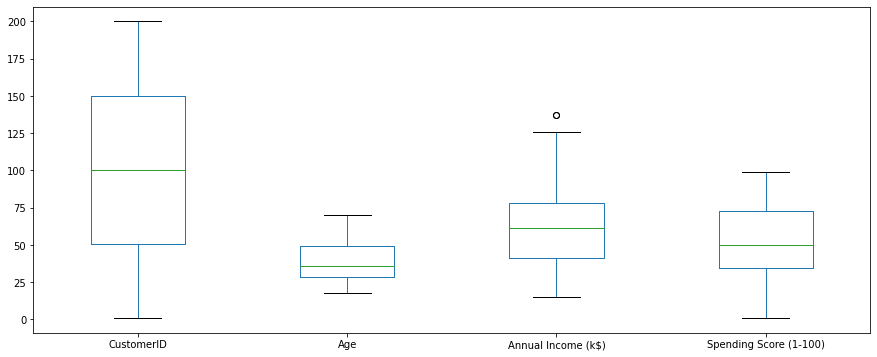

In [8]:
df.plot(kind='box', figsize=(15,6))

Annual income has some value on the higher side we can cap that

In [9]:
Q1 = df['Annual Income (k$)'].quantile(.25)
Q3 = df['Annual Income (k$)'].quantile(.75)

IQR = Q3 - Q1
Low_bound = Q1 - 1.5 * IQR
High_bound = Q3 + 1.5 * IQR
High_bound

132.75

In [10]:
df['Annual Income (k$)'] = df['Annual Income (k$)'].map(lambda x : High_bound if(x>High_bound) else x)

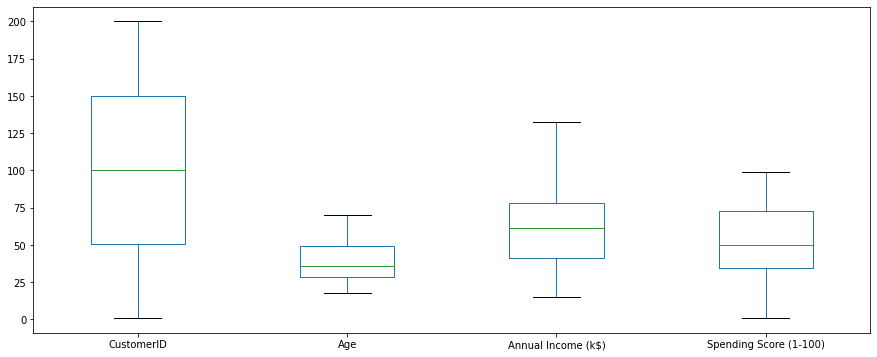

In [11]:
df.plot(kind='box', figsize=(15,6))

### Handle categorical data

In [12]:
df['Gender'] = df['Gender'].map(lambda x : 0 if x == 'Male' else 1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Gender                  200 non-null    int64  
 2   Age                     200 non-null    int64  
 3   Annual Income (k$)      200 non-null    float64
 4   Spending Score (1-100)  200 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 7.9 KB


### Create derived variable

In [14]:
# we will devide spending score by Annual income to get a understanding spending capacity
df['Spending_Capacity'] = df['Spending Score (1-100)'] / df['Annual Income (k$)']

In [15]:
df.head(4)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Spending_Capacity
0,1,0,19,15.0,39,2.6000
1,2,0,21,15.0,81,5.4000
2,3,1,20,16.0,6,0.3750
3,4,1,23,16.0,77,4.8125


### Standarize the values

In [16]:
# we can drop customer id column
df = df.drop(columns='CustomerID')

In [17]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_scaled = scale.fit_transform(df)

In [18]:
df_scaled = pd.DataFrame(data=df_scaled, columns=df.columns)
df_scaled.head(4)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Spending_Capacity
0,-1.128152,-1.424569,-1.745429,-0.434801,1.577229
1,-1.128152,-1.281035,-1.745429,1.195704,4.461139
2,0.886405,-1.352802,-1.707083,-1.715913,-0.714449
3,0.886405,-1.137502,-1.707083,1.040418,3.856033


### Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [19]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [20]:
hopkins(df_scaled)

0.8458027097563239

In [21]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Gender                  200 non-null    float64
 1   Age                     200 non-null    float64
 2   Annual Income (k$)      200 non-null    float64
 3   Spending Score (1-100)  200 non-null    float64
 4   Spending_Capacity       200 non-null    float64
dtypes: float64(5)
memory usage: 7.9 KB


## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [22]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=100)
    kproto = kproto.fit(df_scaled, categorical=[0])
    sse_.append([k, silhouette_score(df_scaled, kproto.labels_)])

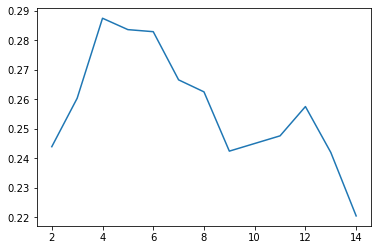

In [23]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

### Sum of Squared Distances

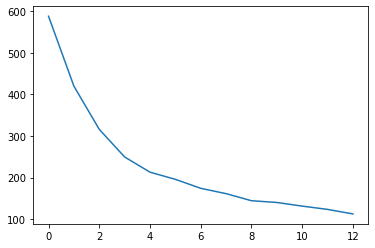

In [24]:
# sum of squared distances
ssd = []
for k in range(2, 15):
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=100)
    kproto = kproto.fit(df_scaled, categorical=[0])
    ssd.append(kproto.cost_)

plt.plot(ssd)

### K-Prototype with some K

In [25]:
# Kmeans with K=5
kproto = KPrototypes(n_clusters=5, init='Cao', random_state=100)
kproto = kproto.fit(df_scaled, categorical=[0])

In [26]:
kproto.cost_

249.64222601177246

In [27]:
df['cluster_id'] = kproto.labels_
df.head(4)

,Gender,Age,Annual Income (k$),Spending Score (1-100),Spending_Capacity,cluster_id
0,0,19,15.0,39,2.6000,4
1,0,21,15.0,81,5.4000,4
2,1,20,16.0,6,0.3750,1
3,1,23,16.0,77,4.8125,4


In [40]:
kp_gender_male = pd.DataFrame(df[df.Gender == 0].groupby(['cluster_id'])['Gender'].count())
kp_gender_female = pd.DataFrame(df[df.Gender == 1].groupby(['cluster_id'])['Gender'].count())
kp_age = pd.DataFrame(df.groupby(['cluster_id'])['Age'].mean())
kp_income = pd.DataFrame(df.groupby(['cluster_id'])['Annual Income (k$)'].mean())
kp_spending_score = pd.DataFrame(df.groupby(['cluster_id'])['Spending Score (1-100)'].mean())
kp_spending_capacity = pd.DataFrame(df.groupby(['cluster_id'])['Spending_Capacity'].mean())

In [41]:
df_result = pd.concat([pd.Series([0,1,2,3,4]), kp_gender_male, kp_gender_female, kp_age, kp_income, kp_spending_score, kp_spending_capacity], axis=1)
df_result.columns = ['cluster_id', 'Gender_Male', 'Gender_Female', 'Age', 'Annual Income (k$)','Spending Score (1-100)', 'Spending_Capacity']
df_result

,cluster_id,Gender_Male,Gender_Female,Age,Annual Income (k$),Spending Score (1-100),Spending_Capacity
0,0,20,14,41.264706,88.375000,16.764706,0.189994
1,1,15,31,28.000000,51.239130,45.304348,0.920197
2,2,18,21,32.692308,86.429487,82.128205,0.977961
3,3,25,33,55.551724,48.482759,41.775862,0.851747
4,4,10,13,25.304348,24.304348,76.521739,3.365291


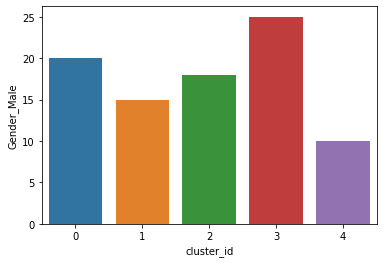

In [42]:
sns.barplot(x=df_result['cluster_id'], y=df_result['Gender_Male'])

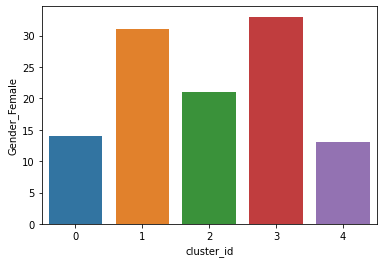

In [43]:
sns.barplot(x=df_result['cluster_id'], y=df_result['Gender_Female'])

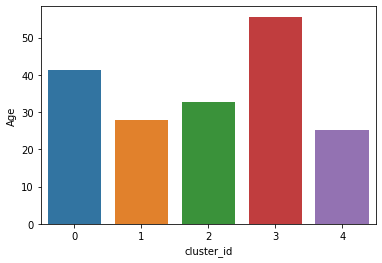

In [44]:
sns.barplot(x=df_result['cluster_id'], y=df_result['Age'])

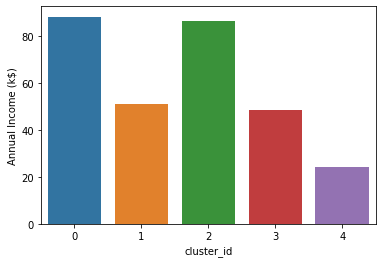

In [45]:
sns.barplot(x=df_result['cluster_id'], y=df_result['Annual Income (k$)'])

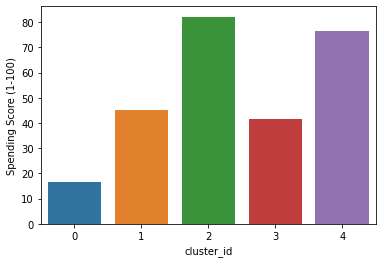

In [48]:
sns.barplot(x=df_result['cluster_id'], y=df_result['Spending Score (1-100)'])

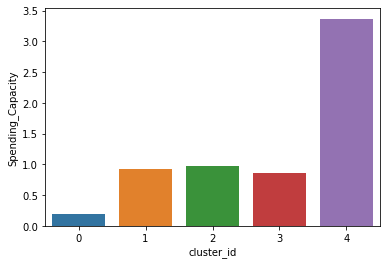

In [49]:
sns.barplot(x=df_result['cluster_id'], y=df_result['Spending_Capacity'])

In [50]:
df_result.columns

Index(['cluster_id', 'Gender_Male', 'Gender_Female', 'Age',
       'Annual Income (k$)', 'Spending Score (1-100)', 'Spending_Capacity'],
      dtype='object')

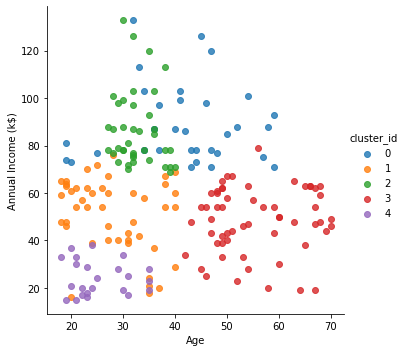

In [53]:
#plot data with seaborn
facet = sns.lmplot(data=df, x='Age', y='Annual Income (k$)', hue='cluster_id', 
                   fit_reg=False, legend=True, legend_out=True)

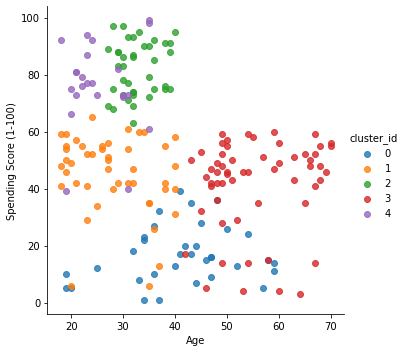

In [54]:
#plot data with seaborn
facet = sns.lmplot(data=df, x='Age', y='Spending Score (1-100)', hue='cluster_id', 
                   fit_reg=False, legend=True, legend_out=True)

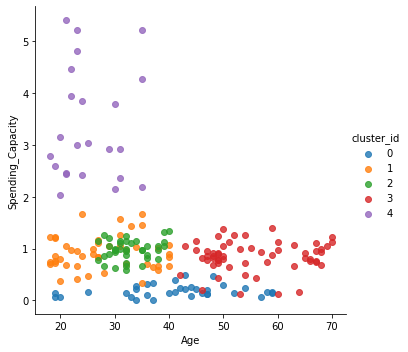

In [55]:
#plot data with seaborn
facet = sns.lmplot(data=df, x='Age', y='Spending_Capacity', hue='cluster_id', 
                   fit_reg=False, legend=True, legend_out=True)

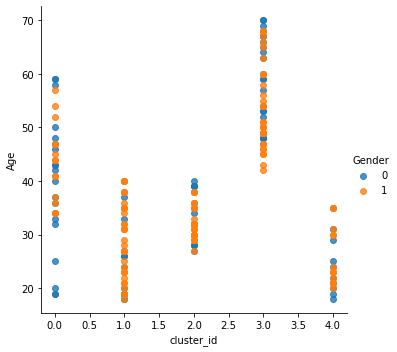

In [59]:
#plot data with seaborn
facet = sns.lmplot(data=df, hue='Gender', y='Age', x='cluster_id', 
                   fit_reg=False, legend=True, legend_out=True)